In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import html
import seaborn as sns
import nltk
import matplotlib.pyplot as plot

from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

In [6]:
train_data = 'data/train.csv'

In [5]:
STOPWORDS = stopwords.words('english')

def preprocessing(text):
    text = text.lower()
    text = html.unescape(text)
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)|(<.*?>)"," ",text).split())
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', text)
    processed_text = []
    for t in text.split(' '):
        t = WordNetLemmatizer().lemmatize(t,'v')
        if t in STOPWORDS:
            continue
        processed_text.append(t)
    return ' '.join(processed_text)

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [7]:
df_train = pd.read_csv(train_data)
# df_test = pd.read_csv('test.csv')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
# Use combined text to train vectorizer
all_texts = [preprocessing(t) for t in df_train['text'].tolist()]
# all_texts = df_train['text'].tolist() + df_test['text'].tolist()
# all_texts = [preprocessing(t) for t in all_texts]

# EDA

In [17]:
# Do preprocessing
df = df_train
df['text'] = df['text'].apply(lambda t: preprocessing(t))
df['keyword'] = df['keyword'].apply(lambda t: str(t).replace("%20", " "))

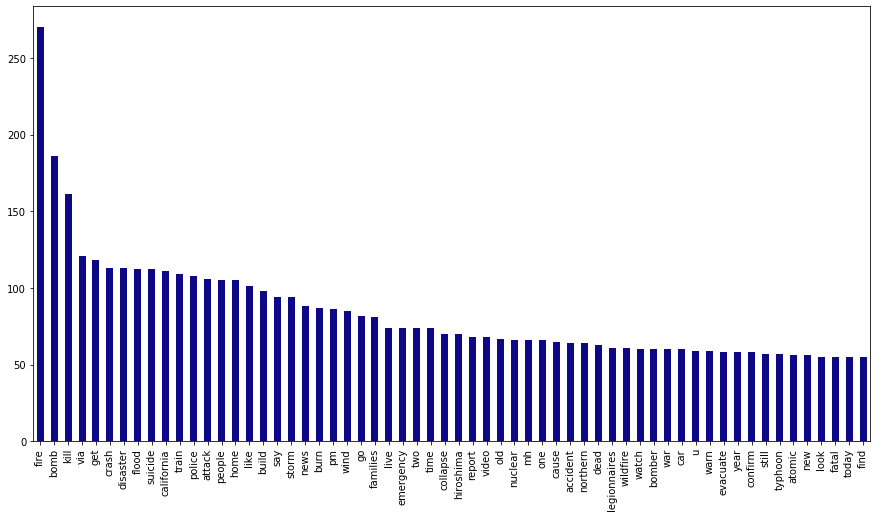

In [18]:
# Display top 60 frequent word in class 1
class_1 = df[df['target'] == 1]
class_1_words = pd.Series(' '.join(class_1['text'].astype(str)).lower().split(" ")).value_counts()[:60]

plot.figure(figsize=(15,8))
class_1_words.plot(kind='bar',stacked=True, colormap='plasma')

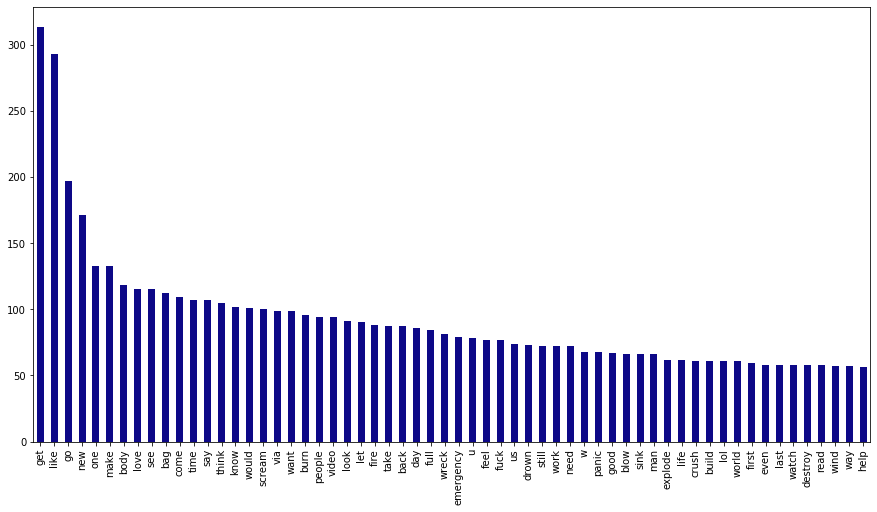

In [19]:
# Display top 60 frequent word in class 0
class_0 = df[df['target'] == 0]
class_0_words = pd.Series(' '.join(class_0['text'].astype(str)).lower().split(" ")).value_counts()[:60]

plot.figure(figsize=(15,8))
class_0_words.plot(kind='bar',stacked=True, colormap='plasma')

In [20]:
words = pd.Series(' '.join(df['text'].astype(str)).lower().split(" ")).value_counts()
# display(words.plot(kind='bar',stacked=True, colormap='plasma'))
unigram_list_1 = []
for idx, val in class_1_words.iteritems():
    weight = val/words[idx]
    if weight > 0.95:
        unigram_list_1.append(idx)
        print(f'words -> {idx}, val1: {val}, val2: {words[idx]}\t{weight}')

words -> california, val1: 111, val2: 116	0.9568965517241379
words -> hiroshima, val1: 70, val2: 71	0.9859154929577465
words -> mh, val1: 66, val2: 67	0.9850746268656716
words -> northern, val1: 64, val2: 64	1.0
words -> legionnaires, val1: 61, val2: 61	1.0
words -> wildfire, val1: 61, val2: 64	0.953125
words -> bomber, val1: 60, val2: 61	0.9836065573770492
words -> typhoon, val1: 57, val2: 58	0.9827586206896551
words -> atomic, val1: 56, val2: 58	0.9655172413793104


In [21]:
unigram_list_0 = []
for idx, val in class_0_words.iteritems():
    weight = val/words[idx]
    if weight > 0.95:
        unigram_list_0.append(idx)
        print(f'words -> {idx}, val1: {val}, val2: {words[idx]}\t{weight}')

In [22]:
bigram_class_1 = get_top_n_bigram(class_1['text'], 60)
bigram_all = get_top_n_bigram(df['text'])
bigram_all = dict(bigram_all)
bigram_list_1 = []
for tup in bigram_class_1:
    weight = tup[1]/bigram_all[tup[0]]
    if weight > 0.95:
        bigram_list_1.append(tup[0])
        print(f'words -> {tup[0]}, val1: {tup[1]}, val2: {bigram_all[tup[0]]}\t{weight}')

words -> suicide bomber, val1: 59, val2: 59	1.0
words -> atomic bomb, val1: 49, val2: 50	0.98
words -> northern california, val1: 41, val2: 41	1.0
words -> oil spill, val1: 38, val2: 39	0.9743589743589743
words -> california wildfire, val1: 32, val2: 32	1.0
words -> bomber detonate, val1: 31, val2: 31	1.0
words -> confirm mh, val1: 29, val2: 29	1.0
words -> detonate bomb, val1: 29, val2: 29	1.0
words -> yr old, val1: 29, val2: 29	1.0
words -> home raze, val1: 29, val2: 29	1.0
words -> latest home, val1: 28, val2: 28	1.0
words -> raze northern, val1: 28, val2: 28	1.0
words -> pkk suicide, val1: 28, val2: 28	1.0
words -> rescuers search, val1: 27, val2: 27	1.0
words -> obama declare, val1: 27, val2: 27	1.0
words -> old pkk, val1: 27, val2: 27	1.0
words -> debris find, val1: 26, val2: 26	1.0
words -> mh malaysia, val1: 26, val2: 26	1.0
words -> families sue, val1: 26, val2: 26	1.0
words -> sue legionnaires, val1: 26, val2: 26	1.0
words -> families affect, val1: 26, val2: 26	1.0
words -> a

In [23]:
bigram_class_0 = get_top_n_bigram(class_0['text'], 60)
bigram_all = get_top_n_bigram(df['text'])
bigram_all = dict(bigram_all)
bigram_list_0 = []
for tup in bigram_class_0:
    weight = tup[1]/bigram_all[tup[0]]
    if weight > 0.95:
        bigram_list_0.append(tup[0])
        print(f'words -> {tup[0]}, val1: {tup[1]}, val2: {bigram_all[tup[0]]}\t{weight}')

words -> cross body, val1: 39, val2: 40	0.975
words -> wreck wreck, val1: 13, val2: 13	1.0


In [24]:
trigram_class_1 = get_top_n_trigram(class_1['text'], 60)
trigram_all = get_top_n_trigram(df['text'])
trigram_all = dict(trigram_all)
trigram_list_1 = []
for tup in trigram_class_1:
    weight = tup[1]/trigram_all[tup[0]]
    if weight > 0.95:
        trigram_list_1.append(tup[0])
        print(f'words -> {tup[0]}, val1: {tup[1]}, val2: {trigram_all[tup[0]]}\t{weight}')

words -> suicide bomber detonate, val1: 31, val2: 31	1.0
words -> northern california wildfire, val1: 29, val2: 29	1.0
words -> latest home raze, val1: 28, val2: 28	1.0
words -> home raze northern, val1: 28, val2: 28	1.0
words -> pkk suicide bomber, val1: 28, val2: 28	1.0
words -> bomber detonate bomb, val1: 28, val2: 28	1.0
words -> raze northern california, val1: 27, val2: 27	1.0
words -> yr old pkk, val1: 27, val2: 27	1.0
words -> old pkk suicide, val1: 27, val2: 27	1.0
words -> families sue legionnaires, val1: 26, val2: 26	1.0
words -> families affect fatal, val1: 26, val2: 26	1.0
words -> affect fatal outbreak, val1: 26, val2: 26	1.0
words -> obama declare disaster, val1: 25, val2: 25	1.0
words -> declare disaster typhoon, val1: 25, val2: 25	1.0
words -> disaster typhoon devastate, val1: 25, val2: 25	1.0
words -> typhoon devastate saipan, val1: 25, val2: 25	1.0
words -> sue legionnaires families, val1: 25, val2: 25	1.0
words -> legionnaires families affect, val1: 25, val2: 25	1.0


In [25]:
trigram_class_0 = get_top_n_trigram(class_0['text'], 60)
trigram_all = get_top_n_trigram(df['text'])
trigram_all = dict(trigram_all)
trigram_list_0 = []
for tup in trigram_class_0:
    weight = tup[1]/trigram_all[tup[0]]
    if weight > 0.95:
        trigram_list_0.append(tup[0])
        print(f'words -> {tup[0]}, val1: {tup[1]}, val2: {trigram_all[tup[0]]}\t{weight}')

words -> cross body bag, val1: 24, val2: 25	0.96
words -> wreck wreck wreck, val1: 11, val2: 11	1.0
words -> top pay pile, val1: 10, val2: 10	1.0
words -> view download video, val1: 9, val2: 9	1.0
words -> beyonce pick fan, val1: 8, val2: 8	1.0


In [26]:
# Retrieve the keywords
group = df.groupby(['keyword','target']).count().unstack()['id']
group.fillna(0, inplace=True)
group['percent'] = group.apply(lambda row: float(row[1]/(row[0]+row[1])),axis=1).astype('float')
print(group[group['percent'] > 0.95])
keywords_list_1 = group[group['percent'] > 0.95].index.tolist()

target             0     1   percent
keyword                             
debris           0.0  37.0  1.000000
derailment       0.0  39.0  1.000000
oil spill        1.0  37.0  0.973684
outbreak         1.0  39.0  0.975000
suicide bomber   1.0  30.0  0.967742
suicide bombing  1.0  32.0  0.969697
typhoon          1.0  37.0  0.973684
wreckage         0.0  39.0  1.000000


In [27]:
group = df.groupby(['keyword','target']).count().unstack()['id']
group.fillna(0, inplace=True)
group['percent'] = group.apply(lambda row: float(row[0]/(row[0]+row[1])),axis=1).astype('float')
print(group[group['percent'] > 0.95])
keywords_list_0 = group[group['percent'] > 0.95].index.tolist()

target          0    1   percent
keyword                         
aftershock   34.0  0.0  1.000000
blazing      33.0  1.0  0.970588
body bag     32.0  1.0  0.969697
body bags    40.0  1.0  0.975610
electrocute  31.0  1.0  0.968750
ruin         36.0  1.0  0.972973


In [28]:
print("Class 1")
print(f'Unigram count: {len(unigram_list_1)}')
print(f'Bigram count: {len(bigram_list_1)}')
print(f'Trigram count: {len(trigram_list_1)}')
print(f'Keyword count: {len(keywords_list_1)}')
print("\n\nClass 0")
print(f'Unigram count: {len(unigram_list_0)}')
print(f'Bigram count: {len(bigram_list_0)}')
print(f'Trigram count: {len(trigram_list_0)}')
print(f'Keyword count: {len(keywords_list_0)}')

Class 1
Unigram count: 9
Bigram count: 53
Trigram count: 60
Keyword count: 8


Class 0
Unigram count: 0
Bigram count: 2
Trigram count: 5
Keyword count: 6


### Train Vectorizer

In [29]:
vectorizer = TfidfVectorizer()
vectorizer.fit(all_texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### Train Classification Model

In [42]:
texts = df_train['text'].tolist()
texts = [preprocessing(t) for t in texts]

In [43]:
X = vectorizer.transform(texts)
y = df_train['target'].tolist()

In [44]:
train, test = train_test_split(df_train, test_size=0.2, random_state=42)

In [45]:
X_train = vectorizer.transform(train['text'].tolist())
y_train = train['target'].tolist()

In [46]:
clf = LogisticRegression().fit(X_train, y_train)

In [58]:
def prediction(row):
    pred = clf.predict(vectorizer.transform([row['text']]))
#     pred = clf.predict_proba(vectorizer.transform([row['text']]))[0][1]
#     if (pred > 0.7):
#         pred = 1
#     elif (pred >= 0.5 and pred <= 0.7):        
#         if row['keyword'] in keywords_list_1:
#             pred = 1
#         elif any(word in row['text'] for word in trigram_list_1):
#             pred = 1
#         elif any(word in row['text'] for word in bigram_list_1):
#             pred = 1
#         elif any(word in row['text'] for word in unigram_list_1):
#             pred = 1
#         elif row['keyword'] in keywords_list_0:
#             pred = 0
#         elif any(word in row['text'] for word in trigram_list_0):
#             pred = 0
#         elif any(word in row['text'] for word in bigram_list_0):
#             pred = 0
#         elif any(word in row['text'] for word in unigram_list_0):
#             pred = 0
#         else:
#             pred = 1
#     elif(pred > 0.3 and pred < 0.5):
#         if row['keyword'] in keywords_list_0:
#             pred = 0
#         elif any(word in row['text'] for word in trigram_list_0):
#             pred = 0
#         elif any(word in row['text'] for word in bigram_list_0):
#             pred = 0
#         elif any(word in row['text'] for word in unigram_list_0):
#             pred = 0
#         elif row['keyword'] in keywords_list_1:
#             pred = 1
#         elif any(word in row['text'] for word in trigram_list_1):
#             pred = 1
#         elif any(word in row['text'] for word in bigram_list_1):
#             pred = 1
#         elif any(word in row['text'] for word in unigram_list_1):
#             pred = 1
#         else:
#             pred = 0
#     else:
#         pred = 0
    return pred

In [59]:
test['pred'] = test.apply(lambda row: prediction(row), axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
print(classification_report(test['target'].tolist(), test['pred'].tolist()))
accuracy_score(test['target'].tolist(), test['pred'].tolist())

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.66      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



0.7997373604727511

# Create upload file

In [ ]:
df_test['target'] = df_test.apply(lambda row: prediction(row), axis = 1)

In [ ]:
df_fin = df_test[['id', 'target']]
df_fin

In [293]:
# Old stack
# text_test = df_test['text'].tolist()
# text_test = [preprocessing(t) for t in text_test]
# X_test = vectorizer.transform(text_test)
# pred = clf.predict(X_test)
# result = {
#     'id': df_test['id'].tolist(),
#     'target': pred
# }
# df_fin = pd.DataFrame(result)
# df_fin

In [396]:
df_fin.to_csv('submission-v5.csv', index=False)

# Validate with previous submission

In [409]:
aaa = pd.read_csv('submission-v5.csv')
print(classification_report(aaa['target'].tolist(), ttt))
accuracy_score(aaa['target'].tolist(), ttt)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2312
           1       1.00      0.97      0.99       951

   micro avg       0.99      0.99      0.99      3263
   macro avg       0.99      0.99      0.99      3263
weighted avg       0.99      0.99      0.99      3263



0.9914189396261109